<a href="https://colab.research.google.com/github/shaqas86/Langgraph_EcoSystem/blob/main/Agentic001_DLIMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AGENTIC DRIVING LICENSE ISSUANCE MANGEMENT SYSTEM

PROJECT STACK = LANGGRAPH REACT AGENT

PROBLEM: USER WANTS ONLINE LEARNER SERVICE FOR DRIVING LICENSE

SOLUTION : APPLY ONLINE LEARNER WITH THE HELP OF DLIMS AGENTIC AI SYSTEM WITH EASE OF USE IN EVERY TYPE OF LANGUAGE

REQUIREMENT : ORGINAL CNIC [FRONT PIC 1 BACK PIC 2]

PASSPORT SIZE PICTURE [WITH WHITE BACKGROUND]

SCHEMA APPLICANT BIO DATA [NAME,FATHER NAME,DATE OF BIRTH, ADDRESS, BLOOD GROUP, HIGHT , CONTACT NO PERSONAL AND EMERGENCY NUMBER, CITY OR DISTRICT ]

SCHEMA FOR DRIVING LICENSE CATEGORY [MCYCLE, MCAR, LTV , TR. AGRI, TR. COMM, INVALID CARRIAGE]

POLICES:

## SERVICES

<LI>  ONLINE LEARNER

In [11]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai langchain_community

In [12]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "DLIMS-Agentic-System"
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

gemini_api_key = userdata.get('GEMINI_API_KEY')
tavily_api_key = userdata.get('TAVILY_API_KEY')

In [13]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")

AIMessage(content='Hello there!  How are you doing today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-cc41bd9e-9632-4311-9b45-407ac3e1667e-0', usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})

In [ ]:
from pydantic import BaseModel, EmailStr
from typing import Optional

class ApplicantBioData(BaseModel):
    name: str
    father_name: str
    date_of_birth: str  # YYYY-MM-DD
    address: str
    blood_group: str
    height: float  # in cm
    contact_no: str
    emergency_no: str
    city_or_district: str

In [ ]:
#2. Driving License Category Schema
from pydantic import BaseModel
from typing import Literal

class LicenseCategory(BaseModel):
    category: Literal["MCYCLE", "MCAR", "LTV", "TR.AGRI", "TR.COMM", "INVALID CARRIAGE"]

In [ ]:
#Tool 1: CNIC Verification
def cnic_verification_tool(cnic_images: list[str]) -> dict:
    """
    Verify CNIC using uploaded images.

    Args:
        cnic_images (list[str]): A list containing paths of the front and back CNIC images.

    Returns:
        dict: Verification status and extracted data from CNIC.
    """
    # Mock example
    return {"status": "Verified", "cnic_data": {"name": "John Doe", "dob": "1985-07-15"}}

In [ ]:
#Tool 2: License Application Submission
def learner_license_tool(details: ApplicantBioData, license_category: LicenseCategory) -> dict:
    """
    Process learner driving license application.

    Args:
        details (ApplicantBioData): Applicant's biodata.
        license_category (LicenseCategory): Selected license category.

    Returns:
        dict: Application status and license tracking number.
    """
    # Mock logic
    return {
        "status": "Application Submitted",
        "tracking_number": "DLIMS-2024-123456",
        "expected_issue_date": "2024-12-20"
    }

[Start]
   ↓
[Detect Intent] --> [Request Assistance] (if needed)
   ↓
[Collect CNIC Details]
   ↓
[Collect Applicant Bio Data]
   ↓
[License Category Selection]
   ↓
[Multilingual Adaptation] --> [Back to Node] (if language adjustment required)
   ↓
[Data Validation] --> [Error Handling] (if validation fails)
   ↓
[Submit Application]
   ↓
[End (Tracking Info)]

In [21]:
#claude
from typing import Optional, Dict, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field
from typing_extensions import override

# Define the application state
class State(TypedDict):
    messages: list
    ask_human: bool
    cnic_front: Optional[str]  # CNIC front image
    cnic_back: Optional[str]   # CNIC back image
    bio_data: Optional[dict]   # Applicant's bio-data
    license_category: Optional[str]  # Selected license category
    application_status: Optional[str]  # Result after application submission

# Custom Tool Classes
class CollectCNICTool(BaseTool):
    name: str = Field(default="collect_cnic", description="Tool to collect CNIC front and back images")
    description: str = "Tool to collect CNIC front and back images"

    @override
    def _run(self, *args: Any, **kwargs: Any) -> Any:
        return "Please upload your CNIC front and back images."

class BioDataTool(BaseTool):
    name: str = Field(default="bio_data", description="Tool to collect applicant's biographical data")
    description: str = "Tool to collect applicant's biographical data"

    @override
    def _run(self, *args: Any, **kwargs: Any) -> Any:
        return "Provide your bio-data (Name, DOB, Address, etc.)."

class LicenseCategoryTool(BaseTool):
    name: str = Field(default="license_category", description="Tool to select driving license category")
    description: str = "Tool to select driving license category"

    @override
    def _run(self, *args: Any, **kwargs: Any) -> Any:
        return "Select a license category (e.g., Motorcycle, Car, LTV)."

class SubmitApplicationTool(BaseTool):
    name: str = Field(default="submit_application", description="Tool to submit driving license application")
    description: str = "Tool to submit driving license application"

    @override
    def _run(self, state: State, *args: Any, **kwargs: Any) -> Any:
        # Simulating submission logic
        if state.get("cnic_front") and state.get("bio_data") and state.get("license_category"):
            return {"status": "Application Submitted", "tracking_id": "DLIMS-2024-001"}
        return {"status": "Error", "message": "Missing required fields."}

# Instantiate tools
tools = [
    CollectCNICTool(),
    BioDataTool(),
    LicenseCategoryTool(),
    SubmitApplicationTool()
]

# Dynamic tool selection
def tools_condition(state: State):
    if not state.get("cnic_front"):
        return "collect_cnic"
    if not state.get("bio_data"):
        return "bio_data"
    if not state.get("license_category"):
        return "license_category"
    return END

# Build the graph
graph_builder = StateGraph(State)

# Add nodes
def chatbot_node(state: State):
    return {"messages": state["messages"] + [{"role": "assistant", "content": "How can I assist you today?"}]}

graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Conditional routing
def select_next_node(state: State):
    # Route based on the dynamic conditions
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"tools": "tools", END: END},
)

# Add start and tool loops
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

# Compile graph
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory
)

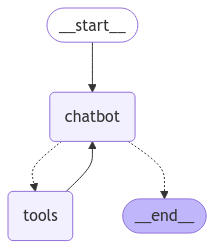

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Initialize state
state = State(
    messages=[],
    ask_human=False,
    cnic_front=None,
    cnic_back=None,
    bio_data=None,
    license_category=None,
    application_status=None,
)

# Start the workflow
events = graph.stream(state)

# Simulate interactions
for event in events:
    if "messages" in event:
        print(f"Agent: {event['messages'][-1]}")
    if "tools" in event:
        tool_result = event["tools"][-1]
        print(f"Tool Result: {tool_result}")